# Dimensionality Reduction

In this lab, we will work with the IMDB to estimate the sentiment of movie reviews. We will study PCA and Sparse PCA in this context, and work using Single Value Decomposition to perform topic analysis. In the context of text mining, we call SVD *Latent Semantic Analysis* (LSA).

LSA is already implemented in Python in scikit-learn in the package [*TruncatedSVD*](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html), we will use that along with the Natural Language Processing library [*NLTK*](https://www.nltk.org/) for our methods.

The general process can be summarized as follows:

1. Load the text in free form.
2. Preprocess the text to normalize it.
3. Calculate LSA.
4. Explore the results.

## Loading text: IMDB database.

This dataset comes from the website Internet Movie Database, and represents 25,000 reviews which were labeled (by humans) as positive or negative, see [here](http://ai.stanford.edu/~amaas/data/sentiment/) for more details. It is a pretty big dataset, so we will work with small samples of 500 positive cases and 500 negative cases.

The uncompressed data is simply a series of text documents, each in its own text file, stored in two classes, one per folder.

The first step is to load the data and create a "corpus". A corpus is, quite simply, a set of documents. Here, we will read the files from our folders, and assign it a sentiment. We need to read the documents one by one, and store them into a dataset which will have our texts, and the tag considering whether they are positive or negative.

### Reading the text

The first step is to read the data into a vector. We need to read from the document path, using the internal system. This package is called *os* and comes pre-installed in Python.


In [1]:
# Install umap
!pip install umap-learn[plot]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 28.4 MB/s eta 0:00:00


In [2]:
# imports
import os
import numpy as np
import pandas as pd
import polars as pl
from scipy.sparse import csr_matrix
import sklearn.feature_extraction.text as sktext
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
import re
from sklearn.manifold import TSNE

# Import umap. Install first if not available!
import umap
import umap.plot

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 314, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,

In [7]:
# Download the data
!gdown https://drive.google.com/uc?id=15AL-2F2Vdg9xlVmHfmeIOs3opnXoxzcP

Downloading...
From: https://drive.google.com/uc?id=15AL-2F2Vdg9xlVmHfmeIOs3opnXoxzcP
To: /content/LSA Sample.zip
100% 829k/829k [00:00<00:00, 93.8MB/s]


In [8]:
!unzip LSA\ Sample.zip

Archive:  LSA Sample.zip
   creating: Lecture_Sample/
   creating: Lecture_Sample/train/
   creating: Lecture_Sample/train/neg/
  inflating: Lecture_Sample/train/neg/0_3.txt  
  inflating: Lecture_Sample/train/neg/100_3.txt  
  inflating: Lecture_Sample/train/neg/101_1.txt  
  inflating: Lecture_Sample/train/neg/102_1.txt  
  inflating: Lecture_Sample/train/neg/103_1.txt  
  inflating: Lecture_Sample/train/neg/104_3.txt  
  inflating: Lecture_Sample/train/neg/105_2.txt  
  inflating: Lecture_Sample/train/neg/106_2.txt  
  inflating: Lecture_Sample/train/neg/107_2.txt  
  inflating: Lecture_Sample/train/neg/108_1.txt  
  inflating: Lecture_Sample/train/neg/109_2.txt  
  inflating: Lecture_Sample/train/neg/10_2.txt  
  inflating: Lecture_Sample/train/neg/110_1.txt  
  inflating: Lecture_Sample/train/neg/111_4.txt  
  inflating: Lecture_Sample/train/neg/112_1.txt  
  inflating: Lecture_Sample/train/neg/113_4.txt  
  inflating: Lecture_Sample/train/neg/114_4.txt  
  inflating: Lecture_Samp

In [10]:
# Read all text files into a single dataframe. Note that the class is 1 for positive reviews.

# List all files in the "pos" directory
dir = 'Lecture_Sample/train/pos/'
fileList = os.listdir(dir)

# Create vector with texts
outtexts = []

# Read the files in the directory and append them with the class to the dataset
for eachFile in fileList:
    with open(dir + eachFile, 'rb', newline = None) as _fp:
        fileData = _fp.read()
        outtexts.append(fileData)
    _fp.close()

# Create dataframe from outputs
pos_texts = pl.DataFrame({'texts': outtexts, 'class': 1})
pos_texts.head()

texts,class
binary,i32
"b""I\x20reached\x20the\x20end\x20of\x20this\x20and\x20I\x20was\x20almost\x20shouting\x20""No,\x20no,""…",1
"b""O\x20my\x20gosh...\x20Just\x20give\x20me\x20a\x20minute\x20to\x20breath.\x20This\x20movie\x20tak""…",1
"b""Bogdonovich's\x20(mostly)\x20unheralded\x20classic\x20is\x20a\x20film\x20unlike\x20j""…",1
"b""Sunday\x20July\x2016,\x208:00pm\x20The\x20Castro,\x20San\x20Francisco<br\x20/><br\x20/>""…",1
"b""""Home\x20Room""\x20came\x20as\x20a\x20total\x20surprise.\x20Not\x20having\x20a\x20clue\x20as\x20t""…",1


In [11]:
# Repeat for negative values
# List all files in the "neg" directory
dir = 'Lecture_Sample/train/neg/'
fileList = os.listdir(dir)

# Create vector with texts
outtexts = []

# Read the files in the directory and append them with the class to the dataset
for eachFile in fileList:
    with open(dir + eachFile, 'rb', newline = None) as _fp:
        fileData = _fp.read()
        outtexts.append(fileData)
    _fp.close()

# Create dataframe from outputs
neg_texts = pl.DataFrame({'texts': outtexts, 'class': 0})
neg_texts.head()

texts,class
binary,i32
"b""Bad\x20plot,\x20bad\x20dialogue,\x20bad\x20acting,\x20idiotic\x20directing,\x20the\x20a""…",0
"b""This\x20movie\x20is\x20by\x20far\x20the\x20worst\x20movie\x20ever\x20made.\x20If\x20you\x20have\x20""…",0
"b""From\x20the\x20beginning\x20of\x20the\x20movie,\x20it\x20gives\x20the\x20feeling\x20the\x20di""…",0
"b""...that\x20Jamie\x20Foxx\x20would\x20ever\x20deliver\x20such\x20a\x20wonderful,\x20Osca""…",0
"b""Before\x20I\x20comment\x20on\x20this\x20movie\x20I\x20just\x20watched\x20on\x20YouTube,\x20I\x20""…",0


In [12]:
# Combine pos and neg texts
all_texts = pl.concat([pos_texts, neg_texts])

# Transform the texts into string dtype
all_texts = all_texts.with_columns(
    pl.col(pl.Binary).map_elements(
        lambda bytes: bytes.decode(errors='ignore'),
        return_dtype=pl.String
    )
)

# Summary of the data
all_texts.describe()

statistic,texts,class
str,str,f64
"""count""","""1000""",1000.0
"""null_count""","""0""",0.0
"""mean""",null,0.5
"""std""",null,0.50025
"""min""","""""All the world's a stage and i…",0.0
"""25%""",null,0.0
"""50%""",null,1.0
"""75%""",null,1.0
"""max""","""yes i have a copy of it on VHS…",1.0


The text is quite dirty, so we'll use regex code to clean it. It is available in Python using the package [re](https://www.rexegg.com/regex-quickstart.html). Regex can be daunting, but it is very rewarding to learn. Do spend some time with it!

In [13]:
# Clean the texts
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
def cleanhtml(text):
    cleantext = re.sub(CLEANR, '', text)
    return cleantext

# Apply the cleaning function to the texts
all_texts = all_texts.with_columns(
    pl.col('texts').map_elements(cleanhtml, return_dtype=pl.String)
)

Now we will transform the text. The following code uses sklearn's [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) which applies a [Term Frequency - Inverse Document Frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) transformation to the text, which means counting how many times a certain concept appears in the document versus the total times it appears in the document, to do the following:

1. Eliminate accents and other characters.
2. Eliminate the so-called "stopwords", or words that are irrelevant to the learning given they are only connectors. These words are [here](https://gist.github.com/ethen8181/d57e762f81aa643744c2ffba5688d33a).
3. Eliminate concepts that are rare (min_df) or too common (max_df). Here we eliminate concepts that appear in less than 5% of documents and those that appear in over 90%.

The last argument calculates a logaritmic (or sublinear) transformation, which is more robust. This effectively transforms our dataset into a fully numeric one!


In [14]:
# Transform the text
TfIDFTransformer = sktext.TfidfVectorizer(strip_accents='unicode', # Eliminate accents and special characters
                      stop_words='english', # Eliminates stop words.
                      min_df = 0.01, # Eliminate words that do not appear in more than 5% of texts
                      max_df = 0.95, # Eliminate words that appear in more than 95% of texts
                      sublinear_tf=True # Use sublinear weights (softplus)
                      )

The model structure of scikit-learn follows always the same:

1. We define the model using the appropriate function directly from the package (as above).

2. We train the model using the "fit" method over the object we created in 1.

3. We apply the model to new data using the "transform" method.

In cases where we want to fit *and* transform the inputs - such as a TF-IDF transform, which is applied over the same data where the weights are "trained" - we can use directly the method "fit_transform", that performs steps 2 and 3 directly.

In [15]:
TfIDF_IMDB = TfIDFTransformer.fit_transform(all_texts['texts'])
TfIDF_IMDB

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 52117 stored elements and shape (1000, 1646)>

The output is a **sparse matrix** with 230 words. These matrices only store the relevant information! They are *much* more efficient in-memory.

The output of the TF-IDF transformer is a sparse matrix. We can check the outputs of the first row with the below code.

In [16]:
print(TfIDF_IMDB[0,:])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 37 stored elements and shape (1, 1646)>
  Coords	Values
  (0, 461)	0.1839218848631596
  (0, 1146)	0.1932302093594195
  (0, 1644)	0.19776538344671651
  (0, 856)	0.10654539799345356
  (0, 189)	0.1665409402771612
  (0, 1231)	0.20025040539460956
  (0, 534)	0.15238189025108945
  (0, 674)	0.15238189025108945
  (0, 1156)	0.13579481973261232
  (0, 220)	0.11508117155911385
  (0, 923)	0.19114837932752543
  (0, 1234)	0.10745678909008409
  (0, 802)	0.18155094193438887
  (0, 1124)	0.134844043620047
  (0, 1626)	0.16445911024526713
  (0, 1487)	0.1321249511874916
  (0, 817)	0.1891733578971289
  (0, 1556)	0.16989126776723057
  (0, 1483)	0.17761798777464183
  (0, 1550)	0.1932302093594195
  (0, 867)	0.12115744708153414
  (0, 1050)	0.1579489147275736
  (0, 30)	0.19297315267792742
  (0, 783)	0.12483254996313065
  (0, 463)	0.1488468886604895
  (0, 640)	0.20025040539460956
  (0, 665)	0.1295852741897548
  (0, 1080)	0.14149040685324143
  (0, 238)	0.

In [17]:
all_texts.head(1)[0,0]

'I reached the end of this and I was almost shouting "No, no, no, NO! It cannot end here! There are too many unanswered questions! The engagement of the dishwashers? Mona\'s disappearance? Helmer\'s comeuppance? The "zombie"? Was Little Brother saved by his father? And what about the head???????" ARGH!! Then I read that at least two of the cast members had passed on and I have to say, I know it probably wouldn\'t be true to Lars von Trier\'s vision, but I would gladly look past replacement actors just to see the ending he had planned! Granted, it would be hard to find someone to play Helmer as the character deserves. Helmer, the doctor you love to hate! I think I have yet to see a more self-absorbed, oblivious, self-righteous character on screen! But, I could overlook a change in actors....I just have to know how it ends!'

 The following vector shows the list of words associated to each index for indexes 30 to 39.

In [18]:
print(TfIDFTransformer.get_feature_names_out()[30:40])

# Let's save the indexes for later.
word_index = TfIDFTransformer.get_feature_names_out ()

['actors' 'actress' 'actresses' 'acts' 'actual' 'actually' 'adam'
 'adaptation' 'add' 'added']


## PCA and Sparse PCA

The total explained variance of the first 2 components is 1.515


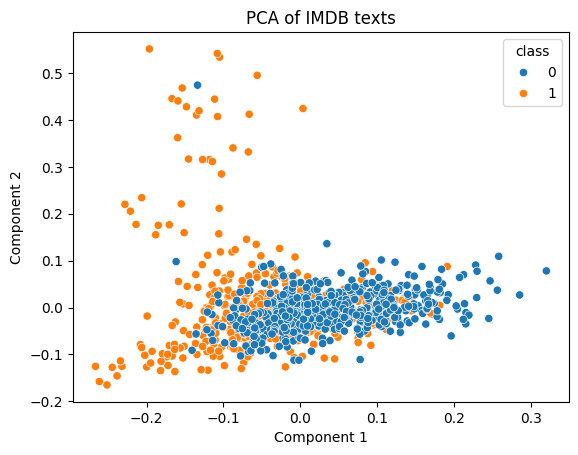

In [19]:
# Do normal PCA on the data set
nPCA = PCA(n_components=2)

# Now we fit. We need to transform our matrix to dense format first.
nPCA.fit(np.asarray(TfIDF_IMDB.todense()))

# Let's calculate the variance of the two components.
total_variance = np.sum(nPCA.explained_variance_) * 100
print('The total explained variance of the first %i components is %.3f' % (nPCA.n_components_, total_variance))

# Let's get the components and plot them, colouring by the class
Z1 = nPCA.transform(np.asarray(TfIDF_IMDB.todense()))
sns.scatterplot(x=Z1[:, 0], y=Z1[:, 1], hue=all_texts['class'])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("PCA of IMDB texts")
plt.show()

Even though we only explain 3% of the data we still get a decent separation! Let's see if Sparse PCA does it better.

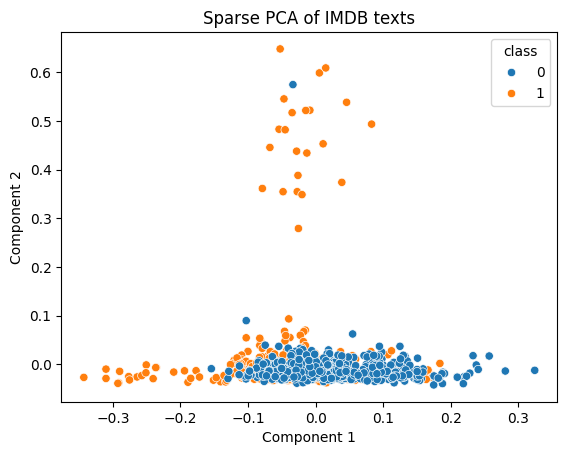

In [20]:
# Now do sparse PCA (Y= ZV), enforcing sparseness on V - that means
# only a few of the original variables should on each latent factor
sPCA = SparsePCA(n_components=2, random_state=0, alpha=0.05)
sPCA.fit(np.asarray(TfIDF_IMDB.todense()))

# Get the results
Z2 = sPCA.transform(np.asarray(TfIDF_IMDB.todense()))  # This are the the Z

# Create plot
sns.scatterplot(x=Z2[:, 0], y=Z2[:, 1], hue=all_texts['class'])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Sparse PCA of IMDB texts")
plt.show()

What happened? Given that we are forcing only some of the 230 components to be a part of the solution, this actually hurts the ability to get the components. Still, it allows to study if some components are more relevant! Now you would check which ones are actually present, like so.

In [21]:
# First component words that are positive
word_index[sPCA.components_[0,:] > 0]

array(['10', '20', '30', 'act', 'acting', 'action', 'actors', 'actually',
       'adam', 'admit', 'annoying', 'awful', 'bad', 'believe', 'better',
       'blonde', 'bored', 'boring', 'budget', 'camera', 'care', 'cheap',
       'cheesy', 'cool', 'couldn', 'crap', 'damn', 'decent', 'denise',
       'did', 'didn', 'don', 'effects', 'face', 'fan', 'feel', 'fun',
       'funny', 'girls', 'glad', 'going', 'good', 'got', 'guess', 'guy',
       'happen', 'happy', 'haven', 'home', 'honestly', 'hope', 'horrible',
       'hot', 'hour', 'hours', 'huge', 'implausible', 'incredibly',
       'instead', 'jamie', 'job', 'joke', 'jokes', 'just', 'kids',
       'killed', 'killing', 'kind', 'knew', 'know', 'lame', 'laugh',
       'let', 'like', 'line', 'lines', 'll', 'looked', 'looks', 'lot',
       'low', 'make', 'maybe', 'mean', 'money', 'movie', 'movies', 'oh',
       'ok', 'okay', 'ones', 'overboard', 'paid', 'pain', 'people',
       'person', 'plot', 'poor', 'pretty', 'probably', 'rating', 'read',
  

In [22]:
# First component words that are negative
word_index[sPCA.components_[0,:] < 0]

array(['appear', 'art', 'artist', 'atmosphere', 'audience', 'based',
       'beautiful', 'beauty', 'best', 'black', 'brilliant', 'casting',
       'central', 'certainly', 'characters', 'chess', 'cinema', 'city',
       'color', 'dark', 'davies', 'deeply', 'depth', 'drama', 'dramatic',
       'early', 'elements', 'emily', 'ending', 'europa', 'excellent',
       'experience', 'eye', 'falls', 'familiar', 'film', 'films', 'final',
       'fine', 'finest', 'fonda', 'form', 'game', 'genius', 'gives',
       'haines', 'highly', 'history', 'human', 'husband', 'images',
       'impression', 'intense', 'intensity', 'italian', 'italy', 'james',
       'joan', 'john', 'king', 'known', 'late', 'level', 'life', 'love',
       'luzhin', 'man', 'marion', 'master', 'masterpiece', 'meet', 'men',
       'mother', 'moves', 'nature', 'novel', 'outstanding', 'past',
       'performance', 'performances', 'period', 'peter', 'picture',
       'piece', 'place', 'play', 'player', 'plays', 'portrayal',
       'pr

In [23]:
# Second component words that are positive
word_index[sPCA.components_[1,:] > 0]

array(['academy', 'actor', 'age', 'agent', 'agree', 'al', 'award', 'ben',
       'benjamin', 'best', 'bitter', 'boys', 'broadway', 'burns',
       'character', 'charles', 'chemistry', 'clark', 'classic',
       'combination', 'comedian', 'comedic', 'comedies', 'comedy',
       'comic', 'commercial', 'couple', 'daughter', 'deserved',
       'deserves', 'died', 'finding', 'form', 'funny', 'george', 'god',
       'golden', 'great', 'hard', 'hilarious', 'hit', 'humor', 'jack',
       'jokes', 'late', 'later', 'laugh', 'lewis', 'living', 'makes',
       'match', 'material', 'matthau', 'meet', 'neil', 'nominated', 'odd',
       'old', 'oscar', 'partner', 'performance', 'personally', 'plain',
       'play', 'played', 'problem', 'question', 'retired', 'reunion',
       'richard', 'right', 'scene', 'screenplay', 'seeing', 'shows',
       'simon', 'small', 'spanish', 'special', 'stage', 'stand', 'stars',
       'straight', 'sunshine', 'supporting', 'team', 'television',
       'thanks', 'theatri

In [24]:
# All components
nPCA.components_

array([[ 0.03691198,  0.00081297, -0.00205139, ..., -0.00037264,
         0.02958666,  0.00553093],
       [-0.01484978,  0.01263713,  0.01208488, ..., -0.00820057,
        -0.00780694, -0.02819208]])

In [25]:
# First component words that are positive
word_index[nPCA.components_[0,:] > 0]

array(['10', '100', '15', '20', '30', '50', '70', '80', '80s', 'able',
       'absolute', 'account', 'act', 'acted', 'acting', 'action',
       'actors', 'actress', 'actually', 'adam', 'admit', 'adventures',
       'ago', 'agree', 'ahead', 'air', 'alas', 'alicia', 'aliens',
       'amateur', 'america', 'amusing', 'ancient', 'angel', 'annoying',
       'anybody', 'anymore', 'aren', 'army', 'aside', 'ask', 'asked',
       'attack', 'attempts', 'attitude', 'attractive', 'average', 'avoid',
       'away', 'awesome', 'awful', 'baby', 'bacon', 'bad', 'badly',
       'ball', 'basically', 'begin', 'beginning', 'believe', 'believed',
       'better', 'bigger', 'bit', 'blame', 'blonde', 'blood', 'bloom',
       'boat', 'body', 'book', 'books', 'bored', 'boring', 'bother',
       'bought', 'brad', 'brain', 'brief', 'budget', 'bunch', 'busy',
       'buy', 'cabin', 'cable', 'came', 'camera', 'cannibal', 'cards',
       'care', 'cares', 'case', 'category', 'cause', 'certain', 'chance',
       'chan

As we can see, the first two components are simply referring to the same thing :( People that discusses movies and films. Go back and play around with the parameters and see whether you can improve these results.

To get meaningful answers, we need to use Singular Value Decomposition.

## Running an SVD decomposition

We can now run the LSA model. For this, we will use the SVD function called [*TruncatedSVD*](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html). Its advantage over PCA is that it works out of the box on sparse data.

Again, we first define it using the TruncatedSVD function.

In [26]:
svd = TruncatedSVD(n_components=100, # How many concepts to extract
          n_iter=100, # How many iterations to run
          random_state=42 # Random state. As SVD is rotation-invariant, we need to set this
          )

As we will apply the model to new data too, we need to first fit the model, not fit and transform simultaneously.

In [27]:
# Train the model!
svd.fit(TfIDF_IMDB)

TruncatedSVD(n_components=100, n_iter=100, random_state=42)

Now we can dig deeper into the model outputs. First, we calculate the explained variance.

In [28]:
# Get total explained variance
print(svd.explained_variance_ratio_.sum())

0.33644967439242773


The explained variance is approximately $67.41\%$ of the total variance using 100 components.

Let's study the relationship between components and words. The matrix *components*, inside our svd object, contains the **principal component matrix**.

In [29]:
# Get component x words matrix
svd.components_

array([[ 0.06063218,  0.00781005,  0.00880783, ...,  0.00937984,
         0.01503101,  0.01668718],
       [ 0.02464666, -0.00258002, -0.00531869, ..., -0.00280606,
         0.03061998,  0.00309863],
       [-0.0145062 ,  0.01200695,  0.01046497, ..., -0.00853021,
        -0.00669974, -0.02670788],
       ...,
       [-0.12074176, -0.00166898, -0.02693418, ..., -0.01457095,
        -0.01781313, -0.01697262],
       [ 0.00041949, -0.00209686, -0.01248429, ..., -0.01320029,
        -0.01884621, -0.06656983],
       [ 0.00892875, -0.00024429,  0.0182507 , ..., -0.01502726,
        -0.00263209, -0.04073009]])

In [30]:
# Get the shape of the matrix
svd.components_.shape

(100, 1646)

We can focus on particular words or concepts too. For example, for the word "action" (in place 3) we can get the following weight vector.

In [31]:
# Get the word related to the third concept
word_index[3]

'15'

In [32]:
# Get the third component
svd.components_[:, 3]

array([ 0.01000376,  0.00528316,  0.00840478,  0.00117268, -0.01801031,
       -0.01193792,  0.01411651,  0.0022491 , -0.00429849,  0.00490976,
        0.01829718,  0.00687842,  0.0033892 , -0.00415893,  0.01067972,
       -0.01113775,  0.02296437, -0.01080641,  0.02234704,  0.01743946,
        0.00596366, -0.01056816,  0.01865882,  0.00953746, -0.01425654,
        0.01511843,  0.00508874, -0.01406735, -0.01186916, -0.01150816,
        0.01361947, -0.00679696,  0.00919496, -0.0005071 ,  0.01576878,
        0.01051933, -0.00852474,  0.01472454, -0.0331498 ,  0.01853749,
        0.00629354,  0.01482088, -0.00789275, -0.00516316, -0.01760546,
        0.00726319,  0.00973328,  0.01424786,  0.00060237,  0.00661169,
        0.02034086,  0.02189661, -0.0221316 , -0.01737256,  0.00670461,
       -0.00151096,  0.00979988, -0.00156808, -0.01694462, -0.01370918,
       -0.00189577, -0.00503968, -0.00893739, -0.00629348, -0.01128689,
        0.01108937, -0.01002704, -0.0261159 , -0.00017545, -0.01

This means that the word "action" is positively related to concept 1, barely negatively related to concept 2 (i.e. that concept does *not* relate to "action"), etc.

To get the five words that relate the most with concept 2, we need to reorder and sort the vector. This can be tricky, so we will use Numpy's *argpartition* function, which will give us the **unsorted** top X values. See the discussion [here](https://stackoverflow.com/questions/6910641/how-to-get-indices-of-n-maximum-values-in-a-numpy-array).

In [33]:
# To get the second concept, remember that Python starts indexing from 0.
indices = np.argpartition(svd.components_[1, :], -10)[-10:]
indices

array([  36,  959,  783, 1573, 1622,  958,  421, 1226,  848,  121])

In [34]:
# Get the words.
[word_index[j] for j in indices]

['adam',
 'movies',
 'just',
 'watch',
 'worst',
 'movie',
 'don',
 'sandler',
 'like',
 'bad']

As we can see, the second concept appears to relate to "bad movies". Try concept 1; it will relate to "popular movies".

The code below displays the singular values.

In [35]:
# Get singular values
svd.singular_values_

array([7.2437773 , 2.86940911, 2.58924207, 2.46512724, 2.40839791,
       2.36719436, 2.33471523, 2.2733285 , 2.22239204, 2.22128609,
       2.19770849, 2.16639607, 2.11821256, 2.0990001 , 2.07115234,
       2.05764648, 2.02977613, 2.01029033, 1.96583287, 1.94798572,
       1.93662308, 1.90360641, 1.89149364, 1.87965905, 1.86477404,
       1.85816687, 1.84475417, 1.83686455, 1.8320985 , 1.82167448,
       1.81488323, 1.80114379, 1.79687252, 1.79527973, 1.77665534,
       1.77275512, 1.76446402, 1.75502413, 1.75208172, 1.74425098,
       1.74000217, 1.73502255, 1.73077675, 1.73035442, 1.72407752,
       1.71819345, 1.70673609, 1.70191751, 1.69476621, 1.68837668,
       1.68462825, 1.68090127, 1.67583923, 1.6719522 , 1.66232684,
       1.65573481, 1.64813462, 1.64460951, 1.64260238, 1.63624122,
       1.63493247, 1.62986639, 1.62811546, 1.6213644 , 1.61582373,
       1.61032592, 1.60536077, 1.60327293, 1.59891636, 1.59513959,
       1.59321575, 1.58729083, 1.58619476, 1.5825912 , 1.58037

Now we have a much better way to study these concepts! Of course, now we can study particular concepts or particular words, as desired.

More importantly, we can now train a model over our reduced space, by using directly the CD matrix as our dataset!

## Non-Linear Visualization

Can we improve this analysis using non-linear methods? We will now study the use of t-SNE and UMAP over the data. We will use two implementations:

1. t-SNE is available in sklearn, in the [sklearn.manifold](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold) subpackage.
2. The more efficient UMAP is available in its own package, called [umap](https://umap-learn.readthedocs.io/en/latest/basic_usage.html).

### t-SNE

In [36]:
n_components = 2
perplexity = 2

In [37]:
tSNEmapper = TSNE(n_components=2,        # How many dimensions to use. Never more than 2 or 3
          init='random',         # First initialization. Sparse matrices need 'random'.  Otherwise use 'pca'
          perplexity=perplexity,     # Read below
          early_exaggeration=50.0,    # How tight are the initial clusters.
          learning_rate='auto',     # Related to above. Leave to auto
          max_iter=10000,        # Very important to let iterate enough
          n_iter_without_progress=50,  # Set early stopping
          metric='cosine',        # Metric to use to calculate distances.
          min_grad_norm=1e-7,      # Minimum gradient to continue iterating
          verbose=1,           # Verbosity
          random_state=42,        # Random seed
          n_jobs=2,           # Parallel processes
          )

Some parameters in TSNE are extremely important. [This](https://distill.pub/2016/misread-tsne/) is a great paper going into detail in this regard.

In particular:

- Perplexity: The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. Different values can result in significantly different results. In general, set to a high value and test a few.
- n_iter: The method must converge to be good. Set high and let the min_grad_norm and n_iter_without_progress stop the training.
- Metric: How to measure distances. Can be any keyword [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html). For text, cosine similarity is [known to work](https://academic.oup.com/bioinformatics/article/22/18/2298/318080).

The other parameters are not as significant. Let's train the model!



In [38]:
TSNE_embedding = tSNEmapper.fit_transform(TfIDF_IMDB)

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.085s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.094992
[t-SNE] KL divergence after 250 iterations with early exaggeration: 525.091003
[t-SNE] KL divergence after 10000 iterations: 1.018575


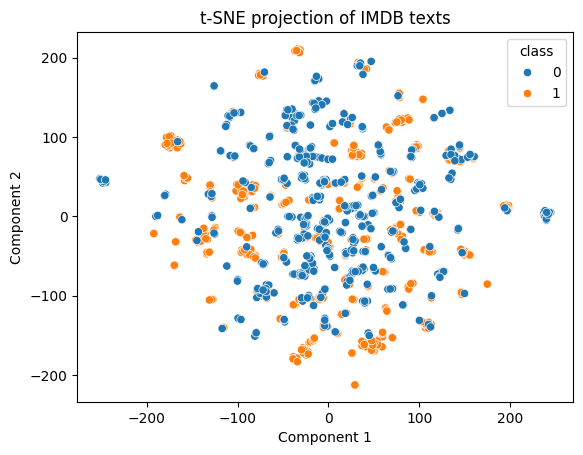

In [39]:
# Create plot
sns.scatterplot(x=TSNE_embedding[:, 0], y=TSNE_embedding[:, 1], hue=all_texts['class'])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("t-SNE projection of IMDB texts")
plt.show()

Here we can see some of the issues with T-SNE. As it is trying to place points according to their perceived distance in the space, only a few really stand out. Everything else gets crammed into the middle, but you can see some of the reviews clustered together. You can improve the model by removing the points that distort the output. Try it!

### UMAP

UMAP (Uniform Manifold Approximation and Projection) is a more sophisticated model based on solid mathematical principles. They are fairly sophisticated, so if you want to check them out in detail, read the [original paper](https://arxiv.org/abs/1802.03426). In particular, Appendix C is of great use if you are familiar with Machine Learning notation.

UMAP is far more efficient than t-SNE, particularly when projecting into more than two dimensions, so it is generally a better method than t-SNE. It is, however, still not very mainstream.

Let's create a 2D projection of our data using UMAP, that works great with sparse matrices.

In [40]:
# Let's create the object
reducer = umap.UMAP(n_neighbors=30,   # Number of neareast neighbours to use.
           n_components=2,   # Number of components. UMAP is robust to larger values
           metric='cosine',   # Metric to use.
           n_epochs=1000,    # Iterations. Set to convergence. None implies either 200 or 500.
           min_dist=0.3,    # Minimum distance embedded points. Smaller makes clumps, larger, sparseness.
           spread=1.0,     # Scale to combine with min_dist
           low_memory=False,  # Run slower, but with less memory.
           n_jobs=-1,      # Cores to use
           verbose=True     # Verbosity
           )

# Now we train and calculate the embedding!
UMAP_embedding = reducer.fit_transform(TfIDF_IMDB)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP(angular_rp_forest=True, low_memory=False, metric='cosine', min_dist=0.3, n_epochs=1000, n_neighbors=30, verbose=True)
Sat Mar 15 18:12:34 2025 Construct fuzzy simplicial set
Sat Mar 15 18:12:34 2025 Finding Nearest Neighbors
Sat Mar 15 18:12:37 2025 Finished Nearest Neighbor Search
Sat Mar 15 18:12:40 2025 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Sat Mar 15 18:12:46 2025 Finished embedding


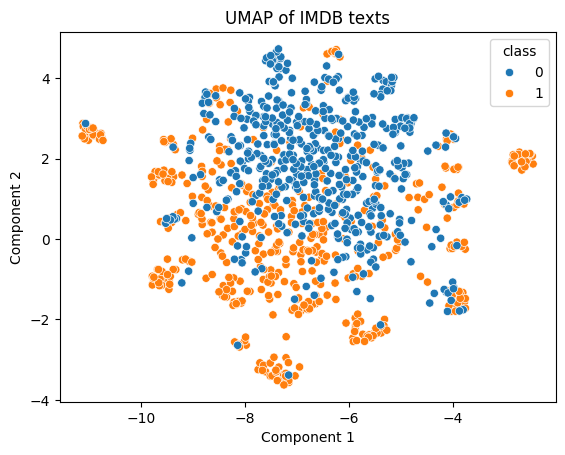

In [41]:
# Create plot
sns.scatterplot(x=UMAP_embedding[:, 0], y=UMAP_embedding[:, 1], hue=all_texts['class'])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("UMAP of IMDB texts")
plt.show()

Or alternatively (and using way less memory) we can simply plot the mapper directly.

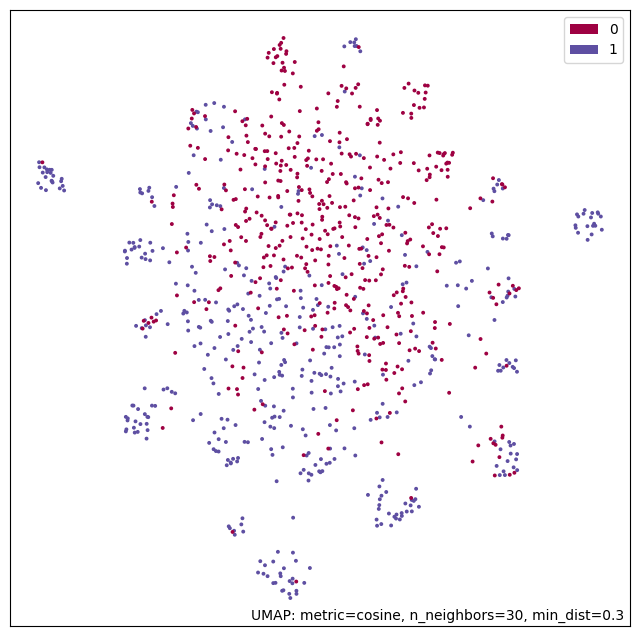

In [42]:
umap.plot.points(reducer, labels=all_texts['class'])
plt.show()

UMAP creates much sparser divisions, and now we can see that the red class is in the lower left, and the blue class in the upper right. Better, but what we can infer is that there is a significant non-linear separation between these two movie reviews, and that this can be better interpreted using non-linear models. There is, however, significant overlap within the classes. This is not an easy problem!